# 🧠 Multi-Agent QA System with RAG and Multi-Agent Collaboration

🚀 **_If you haven’t signed up for LanceDB Cloud yet, click [here](https://cloud.lancedb.com) to get started!_**

This notebook demonstrates an end-to-end question answering system that combines retrieval-augmented generation (RAG) with multi-agent collaboration to achieve accurate, context-aware answers. Built on the [SQuAD v2](https://huggingface.co/datasets/rajpurkar/squad_v2) benchmark, The implementation uses  the following key components:

- **LanceDB-powered** context retrieval
- **AutoGen-managed** agent validation cycles
- **LangChain-optimized** document processing


**💡 Example Output**  
```python  
QUESTION: What is the capital of France?
INSTRUCTIONS: Provide verified answer using the context retrieval workflow

--------------------------------------------------------------------------------

Next speaker: QA_Specialist

QA_Specialist (to chat_manager):

1. Context 1: "Paris is the most populous city in France and the capital of the country."
   Context 2: "The capital and the most populous city of France is Paris, often called the City of Light."
   Context 3: "France, officially the French Republic, has its capital in Paris."

2. Answers from Contexts:
    -From Context 1: Paris
    -From Context 2: Paris
    -From Context 3: Paris

3. Final Answer: Paris.

--------------------------------------------------------------------------------

Next speaker: Fact_Checker

Fact_Checker (to chat_manager):

Paris

--------------------------------------------------------------------------------

Next speaker: Coordinator

Coordinator (to chat_manager):

TERMINATE

--------------------------------------------------------------------------------

Question: What is the capital of France?
Answer: paris
Exact Match: 10000%
F1: 10000%

```

### 🛠️ What You'll Build

*   RAG Pipeline with LanceDB vector store (all-MiniLM-L6-v2 embeddings)
*   AutoGen GroupChat with specialized agent roles (retrieve → generate → verify)
*   Conversation Visualizer showing agent interactions

## Step 1: Install Required Libraries




In [ ]:
!pip install autogen lancedb langchain sentence-transformers datasets langchain-community langchain-openai langchain_huggingface evaluate

## Step 2: Obtain the API key from the [dashboard](https://cloud.lancedb.com)

*  Get the `db uri`

`db uri` starts with `db://`, which can be obtained from the project page on the dashboard. In the following example, `db uri` is `db://test-sfifxz`.

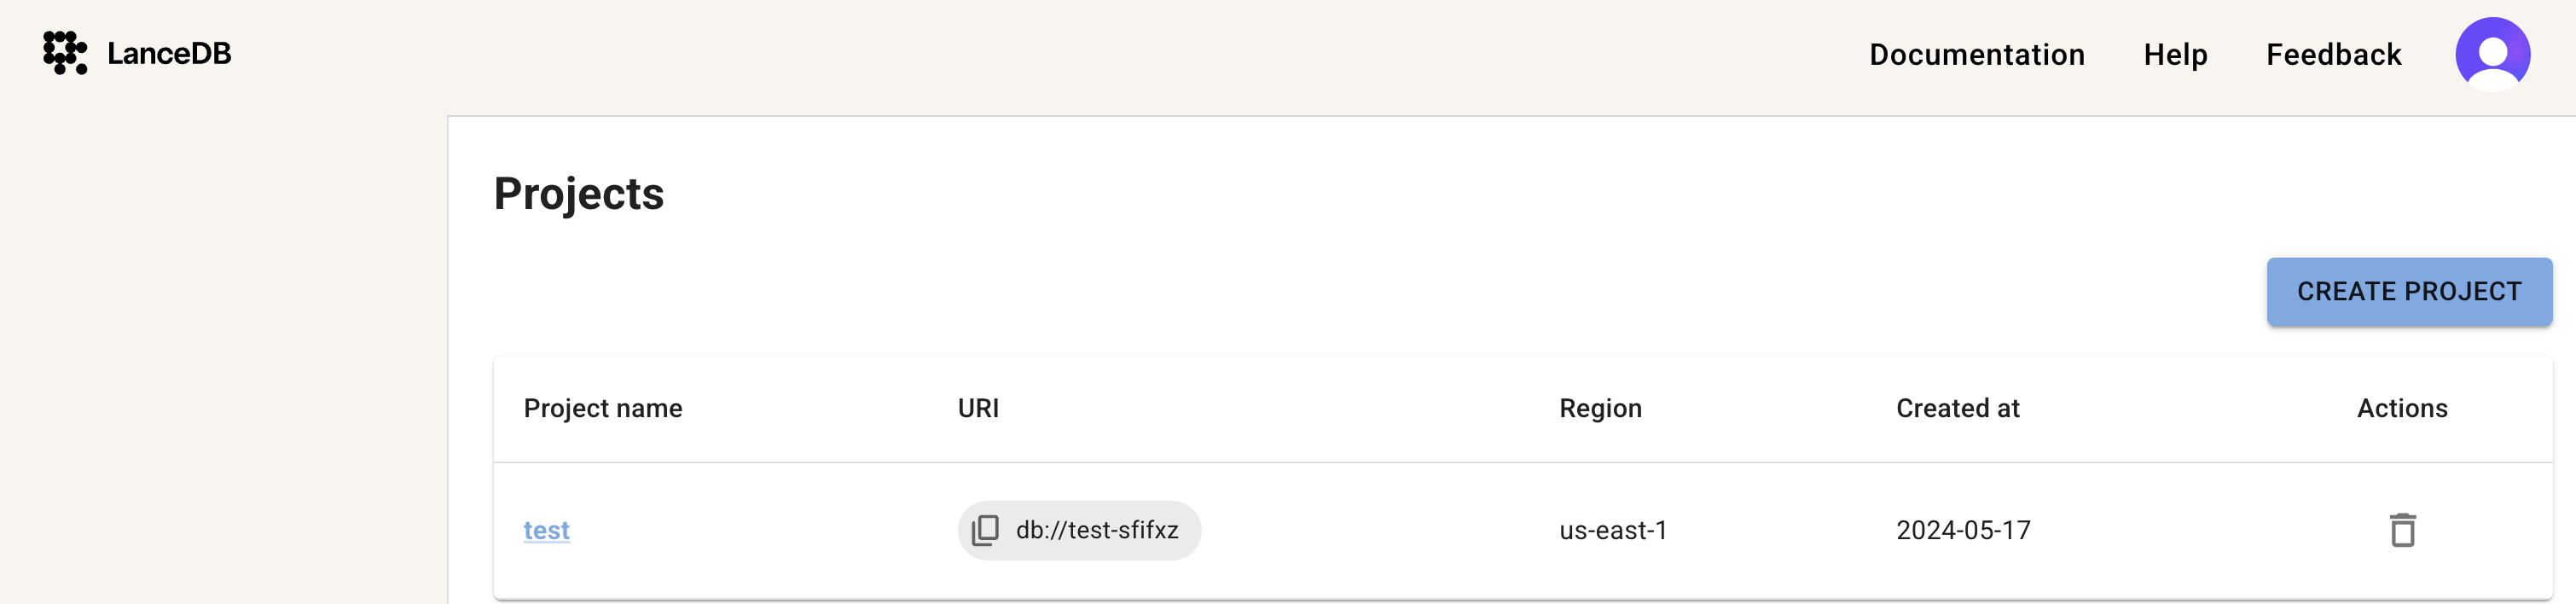

*  Get the `API Key`
Obtain a LanceDB Cloud API key by clicking on the `GENERATE API KEY` from the `table` page.

💡 Copy the code block for connecting to LanceDB Cloud that is shown at the last step of API key generation.
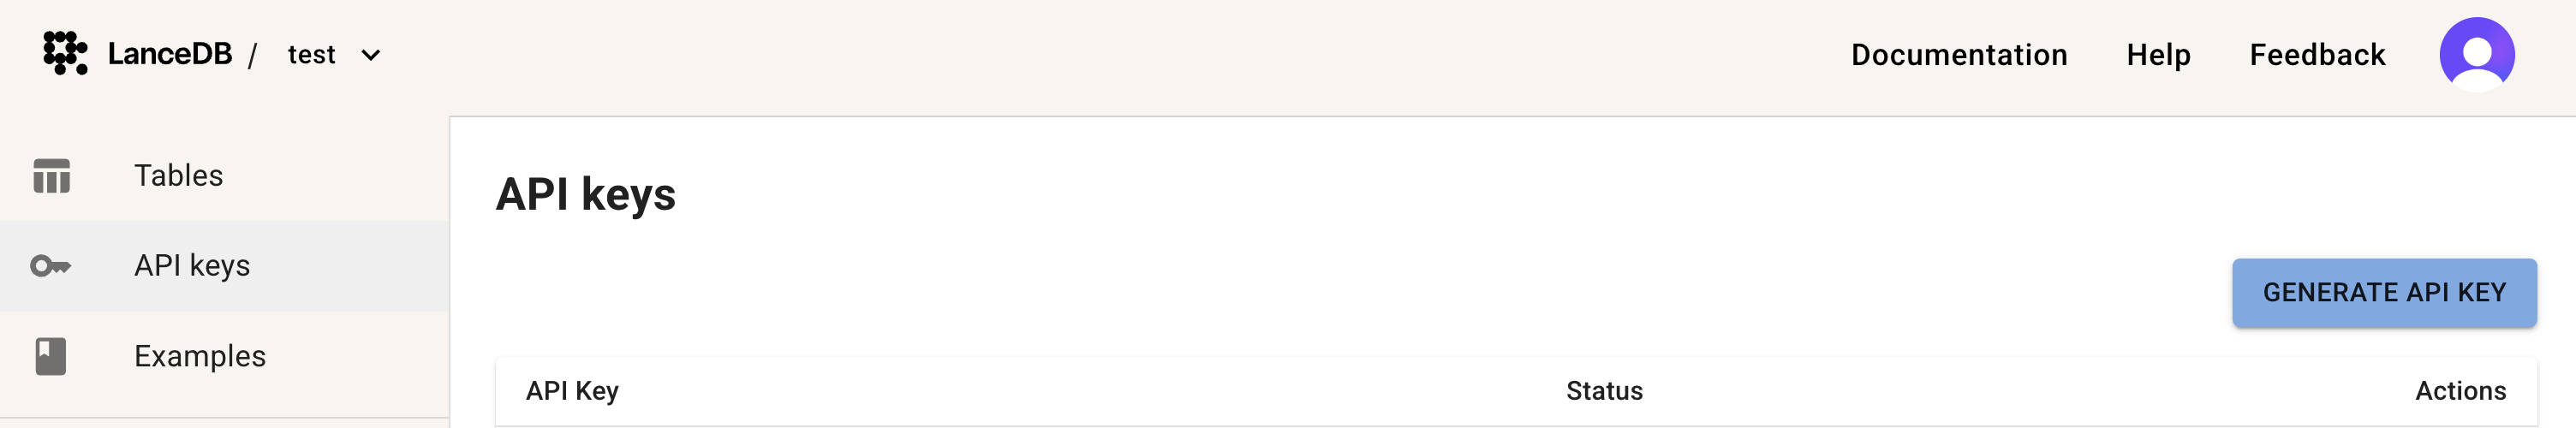

In [66]:
uri = "db://your-db-uri"  # @param {type:"string"}

In [67]:
api_key = "sk_..."  # @param {type:"string"}

paste your OPEN_AI_KEY

In [68]:
openai_api_key = "your-openai-api-key"  # @param {type:"string"}

## Step 3: Import libraries

In [69]:
import lancedb
from autogen import AssistantAgent, UserProxyAgent, GroupChat, GroupChatManager
from datasets import load_dataset
from evaluate import load
from langchain_community.vectorstores import LanceDB
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

## Step 4: Load SQuAD dataset and chunck contexts

Note: We loaded the first 1000 data from the training set to speed up this example.

In [70]:
# Load full dataset
dataset = load_dataset("squad_v2", split="train[:1000]")

# Text splitting with overlap
text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=64)

# Process contexts with answer positions
docs = []
for item in dataset:
    context = item["context"]
    # Find all answer spans in this context
    answer_spans = item["answers"]["answer_start"]
    docs.extend(text_splitter.split_text(context))

## Step 5: Create embeddings and ingest them to LanceDB Cloud

This step might have a few minutes for generating embeddings.

In [71]:
# Create embeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


# Store in LanceDB Cloud
api_key = api_key
uri = uri

db = lancedb.connect(uri=uri, api_key=api_key, region="us-east-1")

# alternatively, you can paste the code block from UI for LanceDB Cloud connection here
# db = lancedb.connect(
#   uri="db://your-db-uri",
#   api_key="sk_...",
#   region="us-east-1"
# )

table_name = "squad_contexts_new"
vector_store = LanceDB.from_texts(
    texts=docs,
    embedding=embeddings,
    uri=uri,  # your remote database URI, e.g. db://...
    api_key=api_key,
    region="us-east-1",
    table_name=table_name,  # Optional, defaults to "vectors"
)
table = db.open_table(table_name)
# drop the unused column
table.drop_columns(["metadata"])

## Step 6: Configure Agent

In the setup, we have:


1.   QA agent: to generate answers from context
2.   Review agent: to validate answers
3.   User proxy: to manage the conversation flow



In [72]:
# Configuration
config_list = [{"model": "gpt-4", "api_key": openai_api_key}]

# Define QA Specialist
qa_agent = AssistantAgent(
    name="QA_Specialist",
    system_message="""Answer ONLY the original question using:
1. Retrieve top 3 contexts
2. Provide exact answer from context
3. Format: "Final Answer: [text]"
DO NOT generate new questions""",
    llm_config={"config_list": config_list},
    function_map={
        "retrieve_contexts": lambda q: vector_store.similarity_search(q, k=3)
    },
)

# Configure Fact Checker
review_agent = AssistantAgent(
    name="Fact_Checker",
    system_message="""Verify answers by:
1. Check context alignment
2. Reject unsubstantiated claims
3. Require direct context support""",
    llm_config={"config_list": config_list},
)

# Set up coordinator
user_proxy = UserProxyAgent(
    name="Coordinator",
    human_input_mode="NEVER",
    code_execution_config=False,
    default_auto_reply="TERMINATE",  # Stops after final answer
    max_consecutive_auto_reply=1,
)

## Step 7 : Orchestrate workflow

The agents collaborate to: generate the initial answer -> verify against context -> refine the answer if needed.



In [73]:
# --- Group Chat Setup ---
groupchat = GroupChat(
    agents=[user_proxy, qa_agent, review_agent],
    messages=[],
    max_round=4,  # Reduced from 8 to prevent question drift
    speaker_selection_method="auto",
    allow_repeat_speaker=False,
)
# Initialize manager
manager = GroupChatManager(groupchat=groupchat, llm_config={"config_list": config_list})

## Step 8 : Set up evaluation pipeline

In [ ]:
import re
import random
from evaluate import squad_metric


def extract_final_answer(conversation):
    for msg in reversed(conversation):
        if "Final Answer:" in msg["content"]:
            answer = msg["content"].split("Final Answer:")[-1]
            return re.sub(r"\[\d+\]", "", answer).strip()
    return "No answer found"


def normalize_eval_text(text):
    text = text.lower().strip()
    text = re.sub(r"[^\w\s]", "", text)  # Keep basic words/whitespace
    text = re.sub(r"\s+", " ", text)  # Single spaces
    return text


def run_qa_pipeline(question, ground_truth):
    user_proxy.reset()
    user_proxy.initiate_chat(
        manager,
        message=f"QUESTION: {question}\nINSTRUCTIONS: Provide verified answer using the context retrieval workflow",
    )

    conversation = user_proxy.chat_messages[manager]
    raw_answer = extract_final_answer(conversation)
    clean_answer = normalize_eval_text(raw_answer)

    prediction = {
        "id": str(random.randint(1000, 9999)),
        "prediction_text": clean_answer,
        "no_answer_probability": 0.0,
    }

    metrics = squad_metric.compute(
        predictions=[prediction],
        references=[
            {
                "id": prediction["id"],
                "answers": {
                    "text": [normalize_eval_text(ground_truth)],
                    "answer_start": [0],
                },
            }
        ],
    )

    return prediction, metrics, conversation

## Step 9 : Let's test!

In [76]:
# Load metrics
squad_metric = load("squad_v2")

test_samples = [
    {"question": "What is the capital of France?", "answer": "Paris"},
    {"question": "Who wrote Romeo and Juliet?", "answer": "William Shakespeare"},
]


for sample in test_samples:
    prediction, metrics, _ = run_qa_pipeline(sample["question"], sample["answer"])
    print(f"\nQuestion: {sample['question']}")
    print(f"Answer: {prediction['prediction_text']}")
    print(f"Exact Match: {metrics['exact']:.0%}")
    print(f"F1: {metrics['f1']:.0%}")
    print("-----------")

Coordinator (to chat_manager):

QUESTION: What is the capital of France?
INSTRUCTIONS: Provide verified answer using the context retrieval workflow

--------------------------------------------------------------------------------

Next speaker: QA_Specialist

QA_Specialist (to chat_manager):

1. Context 1: "Paris is the most populous city in France and the capital of the country."
   Context 2: "The capital and the most populous city of France is Paris, often called the City of Light."
   Context 3: "France, officially the French Republic, has its capital in Paris."

2. Answers from Contexts: 
    -From Context 1: Paris
    -From Context 2: Paris
    -From Context 3: Paris

3. Final Answer: Paris.

--------------------------------------------------------------------------------

Next speaker: Fact_Checker

Fact_Checker (to chat_manager):

Paris

--------------------------------------------------------------------------------

Next speaker: Coordinator

Coordinator (to chat_manager):

T